# Gaussian Mixture Models (GMM) — Visual Guide & Diagnostics

This notebook builds 2D synthetic datasets and visualizes **Gaussian Mixture Models** under different settings:
- **AIC/BIC vs. number of components** (model selection)
- **Covariance structure**: `full`, `tied`, `diag`, `spherical`
- **Initialization**: `kmeans` vs `random`; `n_init` restarts
- **Decision regions** from soft posteriors and **density contours**
- **Soft assignments** (responsibilities) heatmaps
- **Effect of regularization** (`reg_covar`) and stability across seeds
- **Comparison with K-Means** on the same data
- **Anomaly scoring** via negative log-likelihood
- **Sampling from the fitted GMM**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt, warnings

from sklearn.datasets import make_blobs, make_moons
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

np.random.seed(123)
warnings.filterwarnings("ignore")

# Primary dataset: anisotropic/rotated blobs to highlight covariance effects
def make_anisotropic_blobs(n_samples=1200, centers=3, random_state=123):
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=[0.7, 1.2, 0.9], random_state=random_state)
    # Apply a linear transformation to induce correlation (elliptical clusters)
    A = np.array([[0.6, -0.5],
                  [0.4,  0.8]])
    X = X @ A.T
    return X, y

X, y_true = make_anisotropic_blobs()

# Helper: grid for contour plots
def make_grid(X, pad=1.0, n=500):
    x_min, x_max = X[:,0].min()-pad, X[:,0].max()+pad
    y_min, y_max = X[:,1].min()-pad, X[:,1].max()+pad
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, n),
                         np.linspace(y_min, y_max, n))
    XY = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, XY

def plot_gmm_regions(gmm, X, title=""):
    xx, yy, XY = make_grid(X)
    # Posterior probabilities for the most likely component
    resp = gmm.predict_proba(XY)
    labels = resp.argmax(axis=1).reshape(xx.shape)
    # Decision regions
    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, labels, alpha=0.15)
    # Log-density contours (isodensity lines)
    Z = gmm.score_samples(XY).reshape(xx.shape)
    CS = plt.contour(xx, yy, Z, levels=np.percentile(Z, [10, 30, 50, 70, 90]), linestyles=["--","--","-","--","--"])
    plt.clabel(CS, inline=True, fontsize=7, fmt="%.2f")
    plt.scatter(X[:,0], X[:,1], s=14, alpha=0.85, c=gmm.predict(X))
    # Plot component means
    plt.scatter(gmm.means_[:,0], gmm.means_[:,1], s=160, marker="X")
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()

def plot_responsibility_heat(X, gmm, k=0, title=""):
    xx, yy, XY = make_grid(X)
    R = gmm.predict_proba(XY)[:,k].reshape(xx.shape)
    plt.figure(figsize=(6,5))
    im = plt.contourf(xx, yy, R, levels=20)
    plt.colorbar(im)
    plt.scatter(X[:,0], X[:,1], s=10, alpha=0.6)
    plt.title(title + f" — resp for component {k}")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()

## 1) Dataset preview

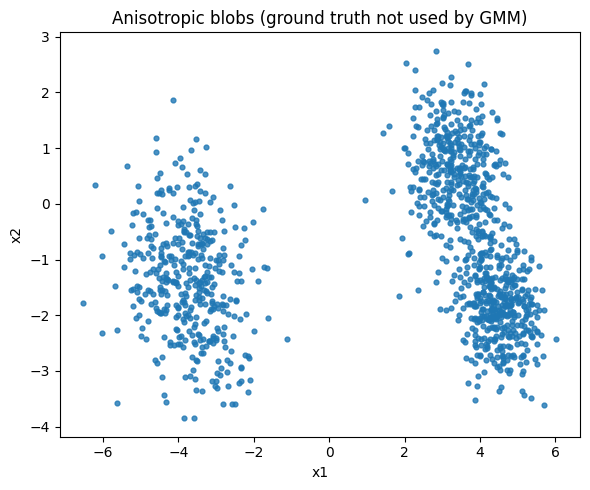

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], s=12, alpha=0.8)
plt.title("Anisotropic blobs (ground truth not used by GMM)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()

## 2) Model selection: AIC/BIC vs number of components

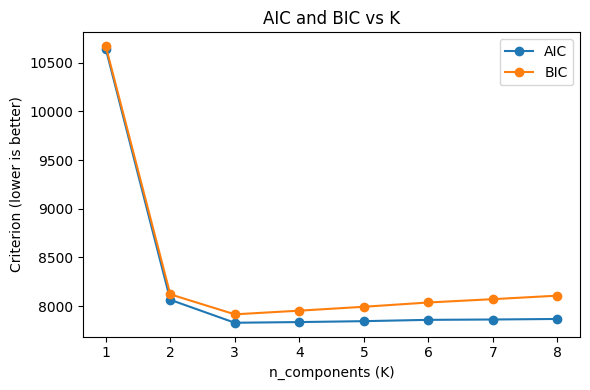

In [ ]:
Ks = range(1, 9)
aics, bics = [], []
for k in Ks:
    gmm = GaussianMixture(n_components=k, covariance_type="full", init_params="kmeans", n_init=5, random_state=123)
    gmm.fit(X)
    aics.append(gmm.aic(X)); bics.append(gmm.bic(X))

plt.figure(figsize=(6,4))
plt.plot(list(Ks), aics, marker="o", label="AIC")
plt.plot(list(Ks), bics, marker="o", label="BIC")
plt.xlabel("n_components (K)"); plt.ylabel("Criterion (lower is better)")
plt.title("AIC and BIC vs K")
plt.legend(); plt.tight_layout(); plt.show()

## 3) Covariance structures (K=3): full, tied, diag, spherical

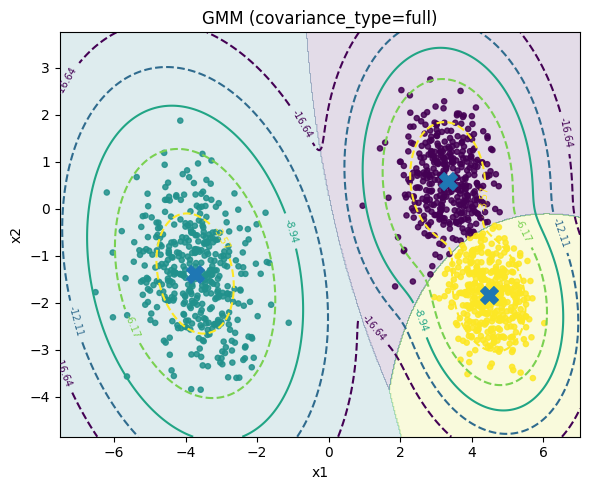

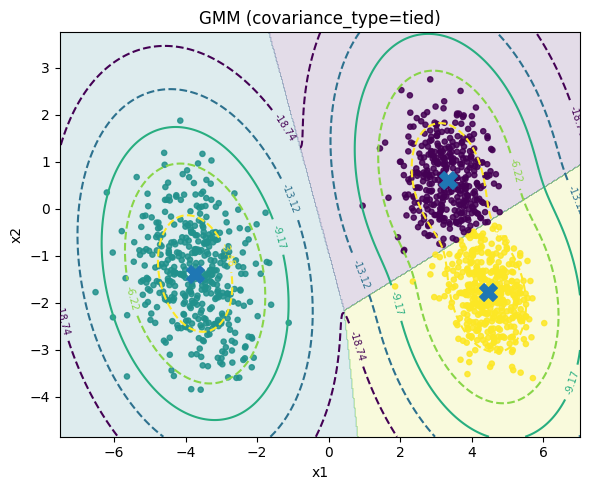

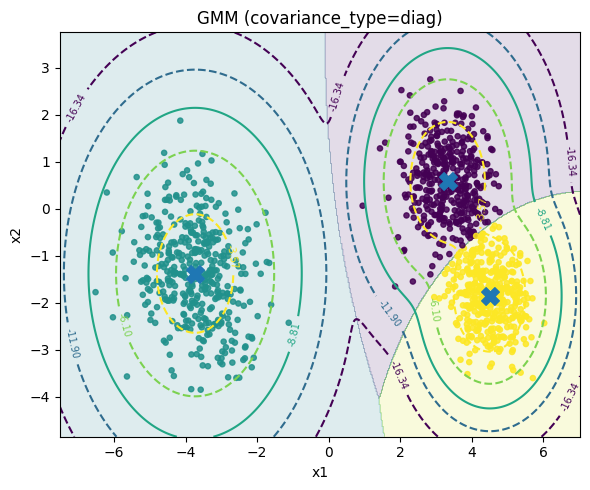

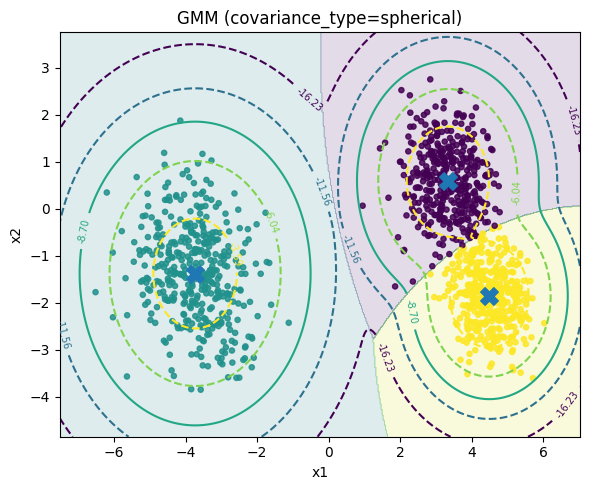

In [ ]:
for cov in ["full","tied","diag","spherical"]:
    gmm = GaussianMixture(n_components=3, covariance_type=cov, init_params="kmeans", n_init=5, random_state=123)
    gmm.fit(X)
    plot_gmm_regions(gmm, X, f"GMM (covariance_type={cov})")

## 4) Initialization: kmeans vs random

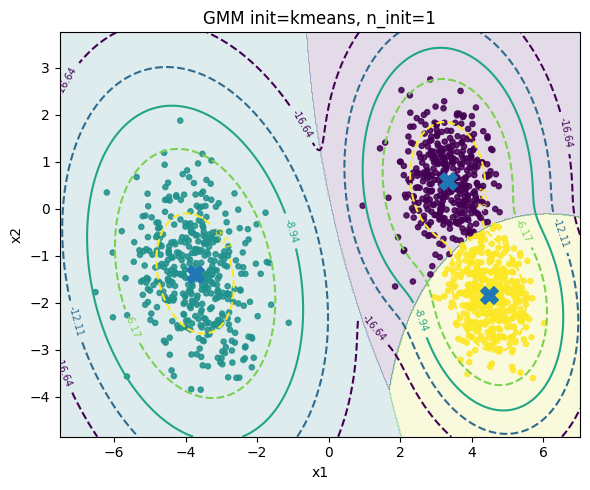

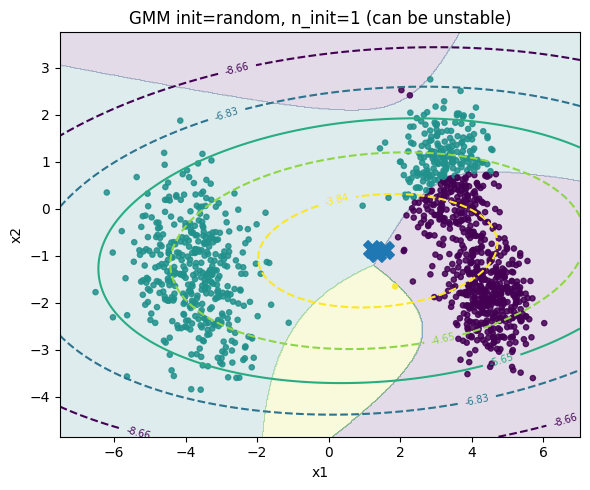

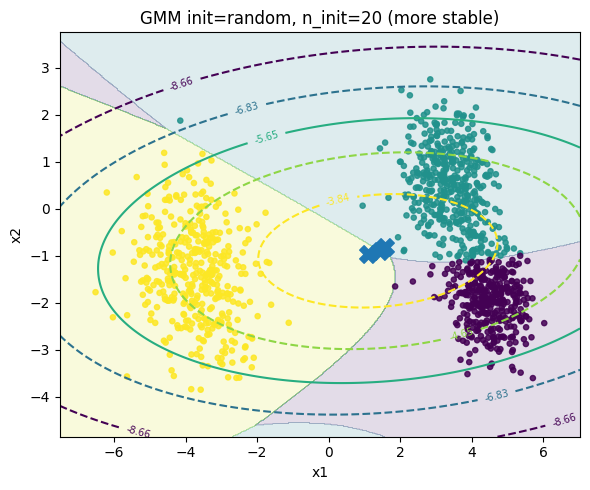

In [ ]:
gmm_k = GaussianMixture(n_components=3, covariance_type="full", init_params="kmeans", n_init=1, random_state=1).fit(X)
plot_gmm_regions(gmm_k, X, "GMM init=kmeans, n_init=1")

gmm_r1 = GaussianMixture(n_components=3, covariance_type="full", init_params="random", n_init=1, random_state=1).fit(X)
plot_gmm_regions(gmm_r1, X, "GMM init=random, n_init=1 (can be unstable)")

gmm_r20 = GaussianMixture(n_components=3, covariance_type="full", init_params="random", n_init=20, random_state=1).fit(X)
plot_gmm_regions(gmm_r20, X, "GMM init=random, n_init=20 (more stable)")

## 5) Responsibilities heatmaps (soft assignments)

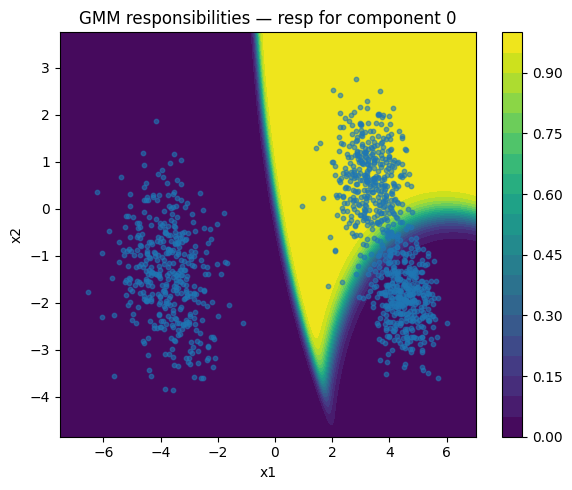

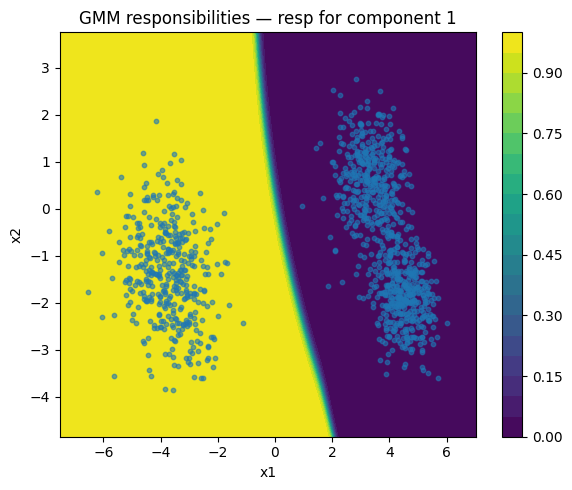

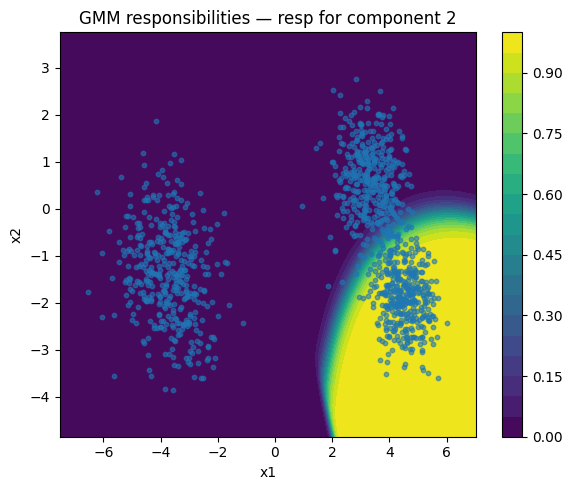

In [ ]:
gmm3 = GaussianMixture(n_components=3, covariance_type="full", init_params="kmeans", n_init=5, random_state=123).fit(X)
for k in range(3):
    plot_responsibility_heat(X, gmm3, k=k, title="GMM responsibilities")

## 6) Regularization (reg_covar)

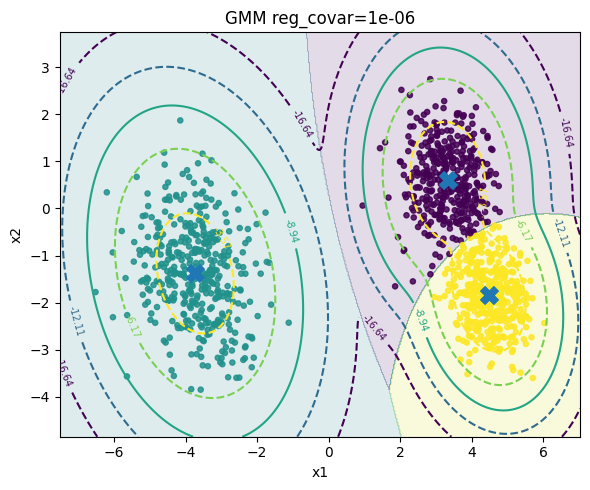

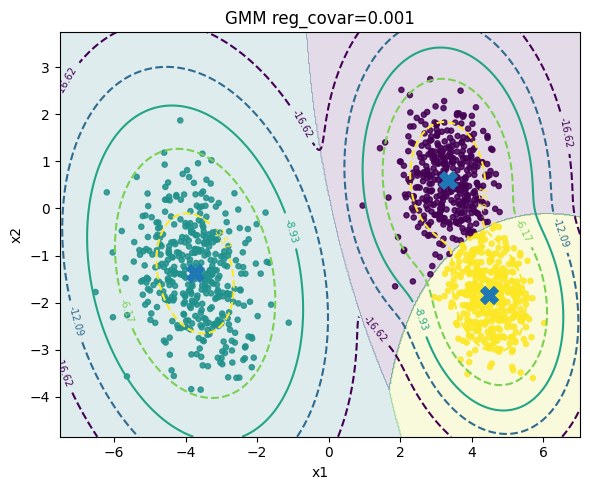

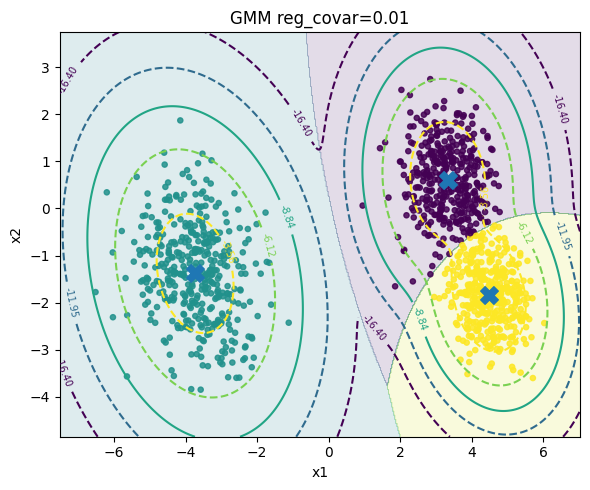

In [ ]:
for reg in [1e-6, 1e-3, 1e-2]:
    gmm = GaussianMixture(n_components=3, covariance_type="full", reg_covar=reg, init_params="kmeans", n_init=5, random_state=123).fit(X)
    plot_gmm_regions(gmm, X, f"GMM reg_covar={reg}")

## 7) Stability across seeds

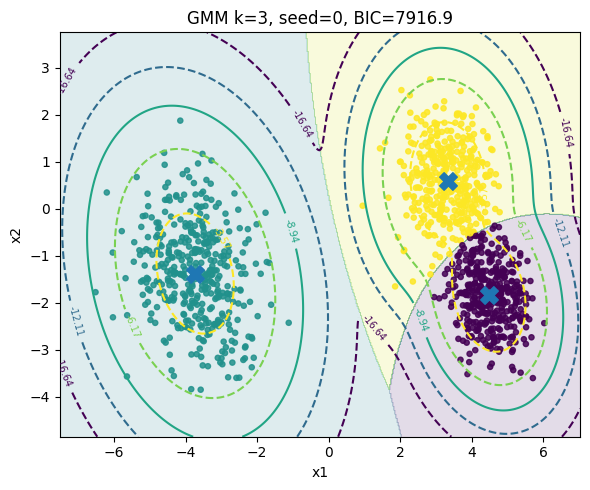

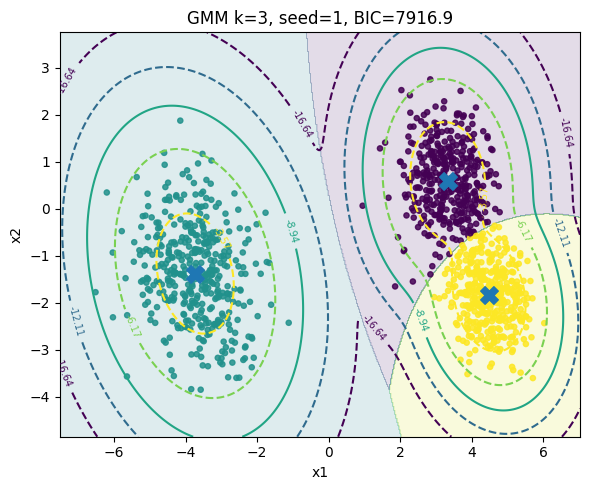

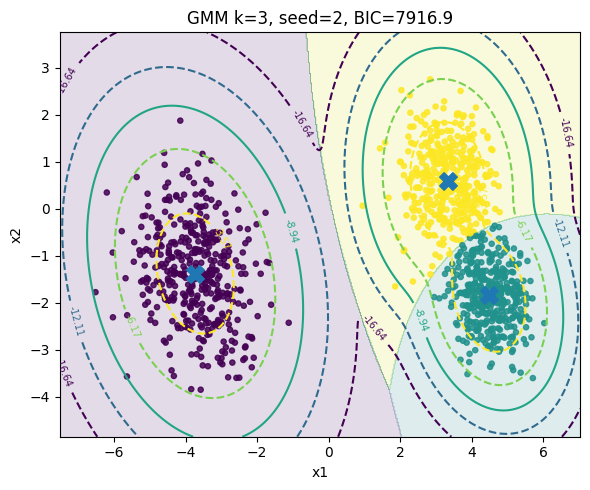

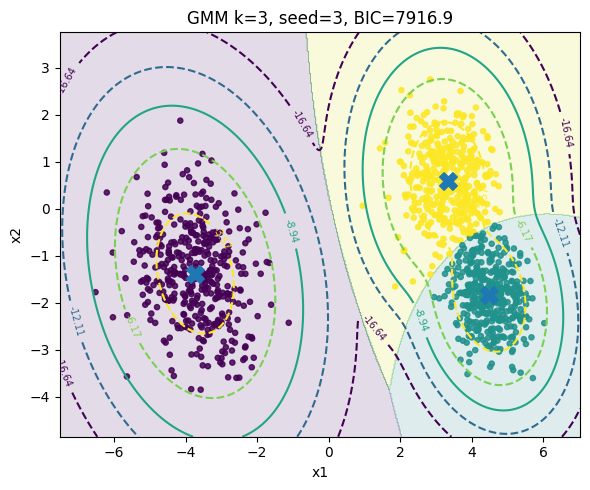

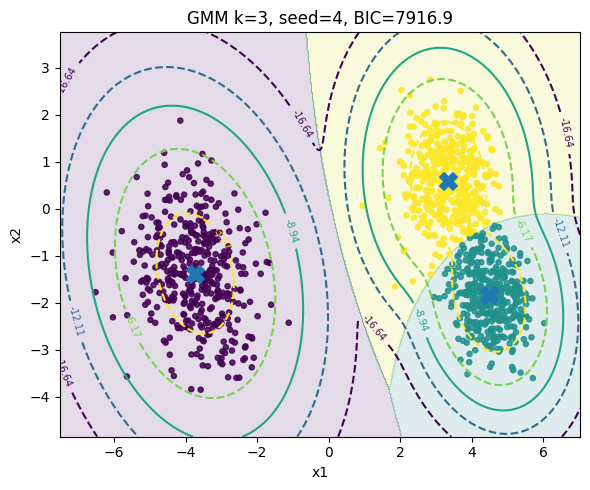

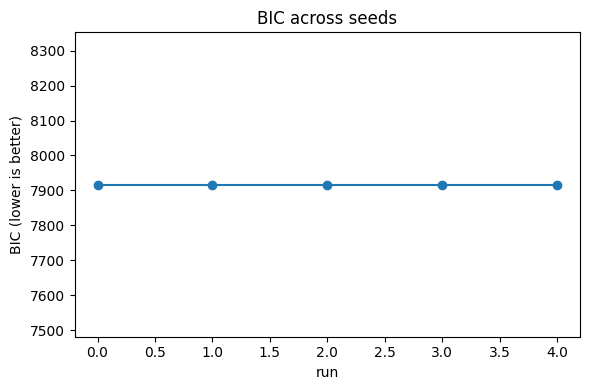

In [ ]:
bics = []
for seed in [0, 1, 2, 3, 4]:
    gmm = GaussianMixture(n_components=3, covariance_type="full", init_params="kmeans", n_init=5, random_state=seed).fit(X)
    bics.append(gmm.bic(X))
    plot_gmm_regions(gmm, X, f"GMM k=3, seed={seed}, BIC={gmm.bic(X):.1f}")

plt.figure(figsize=(6,4))
plt.plot(range(len(bics)), bics, marker="o")
plt.xlabel("run"); plt.ylabel("BIC (lower is better)")
plt.title("BIC across seeds")
plt.tight_layout(); plt.show()

## 8) Comparison: KMeans vs GMM (K=3)

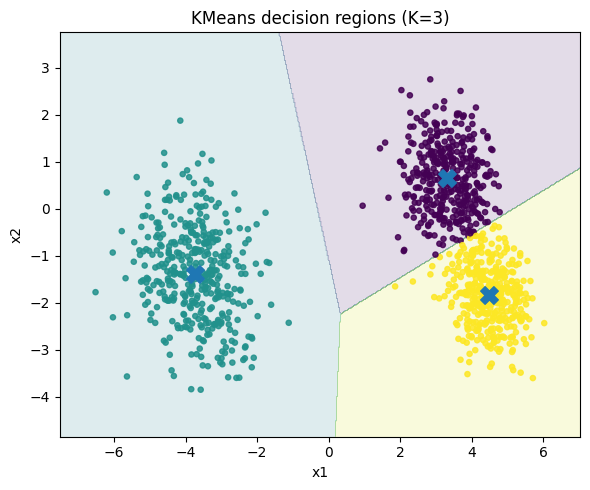

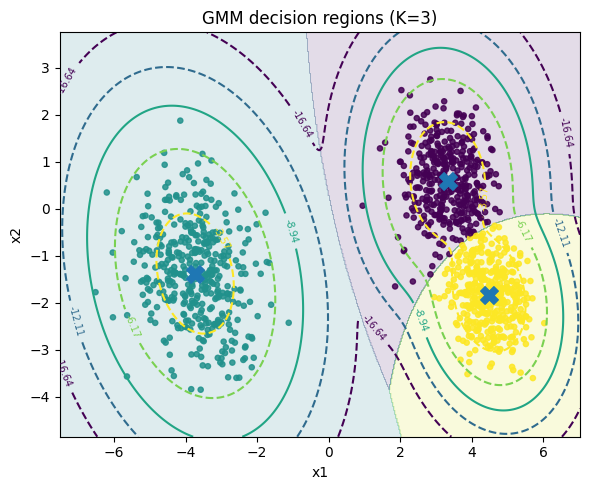

In [ ]:
km = KMeans(n_clusters=3, n_init=20, random_state=123).fit(X)
# KMeans regions
x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
XY = np.c_[xx.ravel(), yy.ravel()]
Z_km = km.predict(XY).reshape(xx.shape)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, Z_km, alpha=0.15)
plt.scatter(X[:,0], X[:,1], c=km.labels_, s=14, alpha=0.85)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=160, marker="X")
plt.title("KMeans decision regions (K=3)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()

# GMM regions for comparison
gmm = GaussianMixture(n_components=3, covariance_type="full", init_params="kmeans", n_init=5, random_state=123).fit(X)
plot_gmm_regions(gmm, X, "GMM decision regions (K=3)")

## 9) Anomaly scoring (negative log-likelihood)

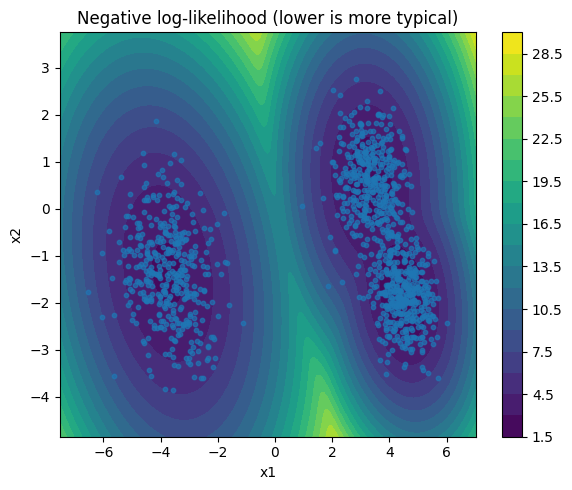

In [ ]:
gmm = GaussianMixture(n_components=3, covariance_type="full", init_params="kmeans", n_init=5, random_state=123).fit(X)
xx, yy, XY = make_grid(X)
nll = -gmm.score_samples(XY).reshape(xx.shape)  # higher = more anomalous (lower density)

plt.figure(figsize=(6,5))
im = plt.contourf(xx, yy, nll, levels=20)
plt.scatter(X[:,0], X[:,1], s=10, alpha=0.7)
plt.colorbar(im)
plt.title("Negative log-likelihood (lower is more typical)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()

## 10) Sampling from the fitted GMM

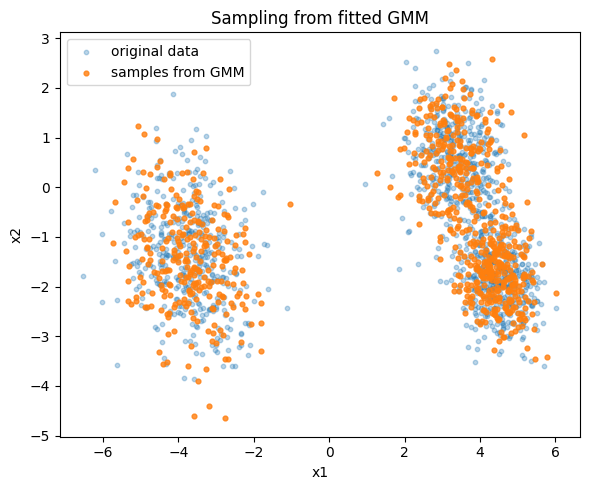

In [ ]:
gmm = GaussianMixture(n_components=3, covariance_type="full", init_params="kmeans", n_init=5, random_state=123).fit(X)
Xs, ys = gmm.sample(n_samples=800)

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], s=10, alpha=0.3, label="original data")
plt.scatter(Xs[:,0], Xs[:,1], s=12, alpha=0.8, label="samples from GMM")
plt.title("Sampling from fitted GMM")
plt.xlabel("x1"); plt.ylabel("x2"); plt.legend()
plt.tight_layout(); plt.show()